In [16]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [17]:
strong_benchmark_file = "out/strong_scaling_results.json"
weak_benchmark_file = "out/weak_scaling.json"

EXCLUDE_FIRST_N = 1

In [18]:
with open(weak_benchmark_file) as f:
    weak = json.load(f)

with open(strong_benchmark_file) as f:
    strong = json.load(f)


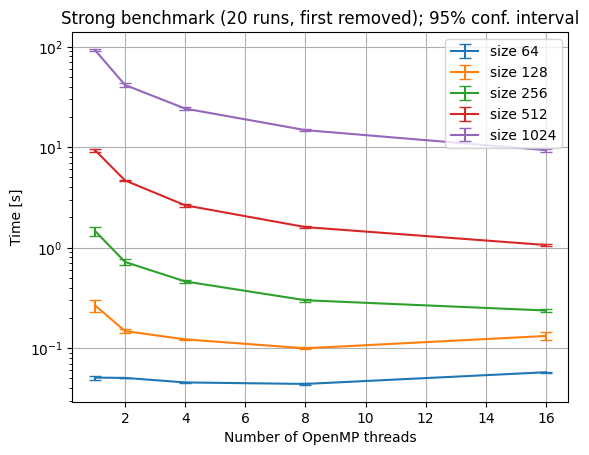

In [19]:
 # plot each threadcount as a line (different color) and each size as a point with error bars

# for each size plot time vs threads
for i, size in enumerate(strong["sizes"]):
    times_for_size = []

    # remove first n runs (warmup)
    for t in strong["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = strong["threads"]

    for t in times_for_size:
        # average
        values.append(sum(t) / len(t))
        # 95% confidence interval
        errors_y.append(1.96 * pd.Series(t).sem())      

    plt.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=f"size {size}",
        capsize=4,
    )

plt.xlabel("Number of OpenMP threads")
plt.yscale("log")
plt.ylabel("Time [s]")
plt.grid()
plt.legend()

plt.title(f"Strong benchmark ({strong['runs']} runs, first removed); 95% conf. interval")

plt.savefig("../report/plots/strong_scaling.pdf")

plt.show()

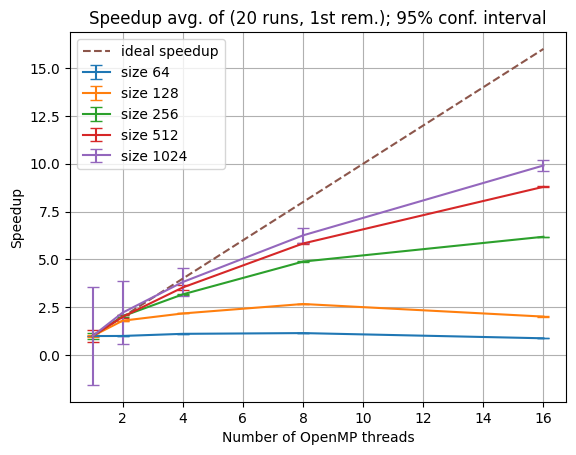

In [20]:
# plot speedup for each size

for i, size in enumerate(strong["sizes"]):

    times_for_size = []

    for t in strong["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = strong["threads"]

    for t in times_for_size:
        values.append(sum(t) / len(t))
        errors_y.append(1.96 * pd.Series(t).sem())

    # speedup
    speedup = [values[0] / v for v in values]

    plt.errorbar(
        threads,
        speedup,
        label=f"size {size}",
        yerr=errors_y,
        capsize=4,
    )

plt.plot(strong["threads"], strong["threads"], "--", label="ideal speedup")

plt.xlabel("Number of OpenMP threads")
plt.ylabel("Speedup")
plt.grid()
plt.legend()

plt.title(f"Speedup avg. of ({strong['runs']} runs, 1st rem.); 95% conf. interval")

plt.savefig("../report/plots/strong_speedup.pdf")

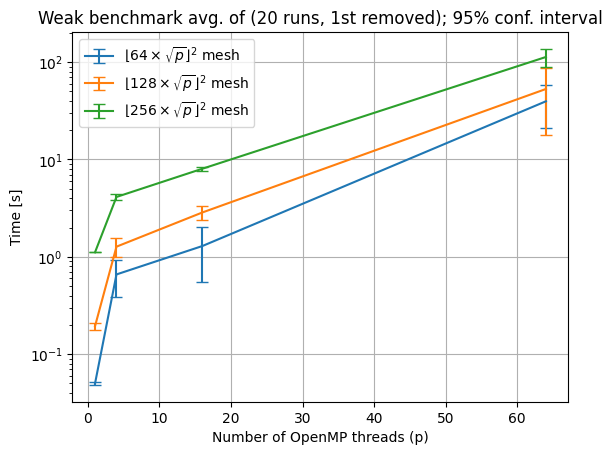

In [52]:
# weak scaling

for i, size in enumerate(weak["sizes"]):
    times_for_size = []

    for t in weak["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = weak["threads"]

    for t in times_for_size:
        values.append(sum(t) / len(t))
        errors_y.append(1.96 * pd.Series(t).sem())

    plt.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=fr"$\lfloor {{{size}}} \times \sqrt{{p}}\rfloor^2$ mesh",
        capsize=4,
    )

plt.xlabel("Number of OpenMP threads (p)")
plt.yscale("log")
plt.ylabel("Time [s]")
plt.grid()
plt.legend()

plt.title(f"Weak benchmark avg. of ({weak['runs']} runs, 1st removed); 95% conf. interval")

plt.savefig("../report/plots/weak_scaling.pdf")


[0.001537513121256534, 0.272896375547999, 0.7359687177834991, 18.47907527769337]
[1.0, 0.07556198942031432, 0.038588751626269645, 0.001256998302519821]
[0.014985758190429408, 0.2856613642316892, 0.46608211094620505, 34.94641153147379]
[1.0, 0.15211217107061817, 0.06772234908118825, 0.003647639298219423]
[0.0022604294544532003, 0.31192865124590036, 0.39171868888846495, 23.626781883779284]
[1.0, 0.2697510463285054, 0.13835470116950002, 0.009834041577614487]


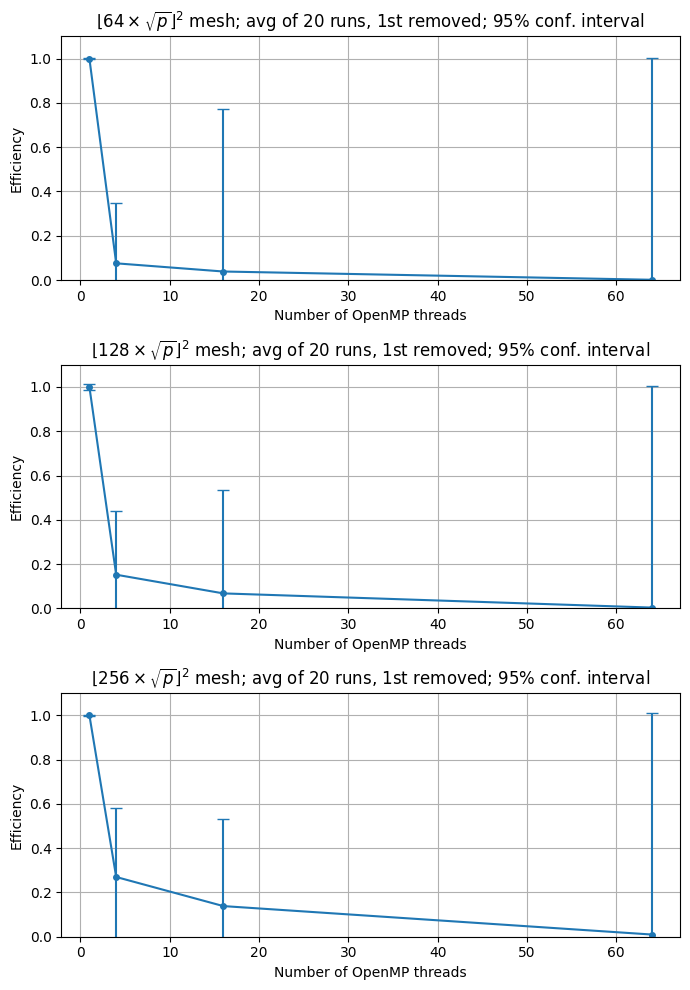

In [50]:
# plot efficiency

fig, axs = plt.subplots(len(weak["sizes"]), 1, figsize=(7, 10))

for i, size in enumerate(weak["sizes"]):

    ax = axs[i]

    times_for_size = []

    for t in weak["times"][i]:
        times_for_size.append(t[EXCLUDE_FIRST_N:])

    values = []
    errors_y = []
    threads = weak["threads"]

    base_time = sum(times_for_size[0]) / len(times_for_size[0])

    for t in times_for_size:
        values.append(base_time / (sum(t) / len(t)))
        errors_y.append(1.95 * pd.Series(t).sem())

    print(errors_y)
    print(values)

    # clamp error to 1
    errors_y = [min(1, e) for e in errors_y]

    ax.errorbar(
        threads,
        values,
        yerr=errors_y,
        label=f"size {size}",
        capsize=4,
        marker="o",
        markersize=4,
    )

    ax.set_xlabel("Number of OpenMP threads")
    ax.set_ylabel("Efficiency")
    # ax.set_yscale("log")
    ax.grid()
    
    # set limits
    ax.set_ylim(0, 1.1)

    # set title for each subplot
    ax.set_title(
        fr"$\lfloor {{{size}}} \times \sqrt{{p}}\rfloor^2$ mesh; avg of {weak['runs']} runs, 1st removed; 95% conf. interval")

fig.tight_layout()

plt.savefig("../report/plots/weak_efficiency.pdf")

In [46]:
import math


for base_size in [64, 128, 256]:
    image_base_operation = base_size ** 2 
    print(f"Ops: {base_size}: {image_base_operation}")
    for threads in [1, 4, 16, 64]:
        s = base_size * math.sqrt(threads)
        base_size_operations = base_size * base_size
        operations_per_thread = base_size_operations * threads
        size_per_thread = math.ceil(math.sqrt(operations_per_thread))

        operations_per_thread = s ** 2 / threads
        print(f"\t Threads {threads}: ops: {operations_per_thread}: size: {size_per_thread}")


Ops: 64: 4096
	 Threads 1: ops: 4096.0: size: 64
	 Threads 4: ops: 4096.0: size: 128
	 Threads 16: ops: 4096.0: size: 256
	 Threads 64: ops: 4096.0: size: 512
Ops: 128: 16384
	 Threads 1: ops: 16384.0: size: 128
	 Threads 4: ops: 16384.0: size: 256
	 Threads 16: ops: 16384.0: size: 512
	 Threads 64: ops: 16384.0: size: 1024
Ops: 256: 65536
	 Threads 1: ops: 65536.0: size: 256
	 Threads 4: ops: 65536.0: size: 512
	 Threads 16: ops: 65536.0: size: 1024
	 Threads 64: ops: 65536.0: size: 2048
